### TFC Demo

For this demonstration we will approximate the solution $u(x,y,t)$ of the PDE
$$u_t u_x + u_y = t^2 + (t - 1)x + 2 \pi x \cos(2 \pi xy) + (2ty + xy) \left( (t -1)y + 2 \pi y \cos(2 \pi x y) \right)$$
for $x,y,t \in [0,1]$, subject to
$$u(0,y,t) = t^2y$$
$$u(x,0,t) = 0$$
$$u(x,y,1) = y + sin(2\pi xy)$$
The true solution of this equation is given by
$$u(x,y,t) = \sin(2 \pi x y) + t^ 2y + (t - 1) x y$$

We begin with the construction of the constrained expression.

In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy

from numba import jit

In [2]:
x, y, t = sym.symbols("x y t")
L, H = sym.symbols("L H")
var_list = [x, y, t]
c = sym.Function("c")
g = sym.Function("g")

In [3]:
def b_operator(variable, order, value, function):
    return function.diff(variable, order).subs(variable, value)

def h(i, var):
    return var**(i)

Step 1: Construct the CE tensor.

In [4]:
q_value = [[0], [0], [1]]
diff_var = [[x], [y], [t]]
diff_order = [[0], [0], [0]]

In [5]:
tensor_dim = [len(l) + 1 for l in  q_value]
tensor = [[[sym.Integer(0) for i in range(tensor_dim[2])] for j in range(tensor_dim[1])] for k in range(tensor_dim[0])]

In [6]:
for i in range(tensor_dim[0] - 1):
    tensor[i + 1][0][0] = b_operator(x, diff_order[0][i],q_value[0][i], c(x,y,t))
for j in range(tensor_dim[1] - 1):
    tensor[0][1 + j][0] = b_operator(y, diff_order[1][j],q_value[1][j], c(x,y,t))
for k in range(tensor_dim[2] - 1):
    tensor[0][0][1 + k] = b_operator(t, diff_order[2][k],q_value[2][k], c(x,y,t))

In [7]:
def inner_tensor_entry(indices,m):
    res = c(x,y,t)
    for n in reversed(range(len(var_list))):
        if(indices[n] == 0):
            continue
        res = b_operator(
            diff_var[n][indices[n] - 1], 
            diff_order[n][indices[n] - 1], 
            q_value[n][indices[n] - 1], res
            )
    return res*((-1)**(m+ 1))

In [8]:
for i in range(tensor_dim[0]):
    for j in range(tensor_dim[1]):
        for k in range(tensor_dim[2]):
            indices = [i, j, k]
            m = len(indices) - indices.count(0)
            if m > 1:
                tensor[i][j][k] = inner_tensor_entry(indices,m)

Step 2: Find the switching functions.

In [9]:
v = []
for k, var in enumerate(var_list):
    l_k_range = range(len(q_value[k]))
    alpha_k_system = sym.Matrix([[b_operator(var, diff_order[k][i], q_value[k][i], h(j, var)) for j in l_k_range] for i in l_k_range])
    alphas = alpha_k_system.solve(sym.eye(*alpha_k_system.shape))
    v_k = [1] + [sum(alphas[i,k]*h(i,var) for i in l_k_range) for k in l_k_range]
    v.append(v_k)

In [10]:
constrained_expression = g(x,y,t)
for i in range(tensor_dim[0]):
    for j in range(tensor_dim[1]):
        for k in range(tensor_dim[2]):
            v_term = v[0][i]*v[1][j]*v[2][k]
            A_term = tensor[i][j][k]*v_term
            B_term = tensor[i][j][k].subs(c,g)*v_term
            constrained_expression += A_term - B_term

Step 3: Substitute $c(x,y,t)$ by the evalutuation of the boundary conditions. 

In [11]:
ce_final = constrained_expression.simplify().subs(
    {
        c(0,0,1) : 0,
        c(0,0,t) : 0,
        c(0,y,1) : y,
        c(x,0,1) : 0,
        c(x,0,t) : 0,
        c(x,y,1) : y + sym.sin(2*sym.pi*x*y),
        c(0,y,t) : t*t*y
    })

display(ce_final)

t**2*y - g(0, 0, 1) + g(0, 0, t) + g(0, y, 1) - g(0, y, t) + g(x, 0, 1) - g(x, 0, t) - g(x, y, 1) + g(x, y, t) + sin(2*pi*x*y)

Now that the constrained expression is computed, we proceed to plug it into the differential equation.

In [12]:
lhs = ce_final.diff(t)*ce_final.diff(x) + ce_final.diff(y)
rhs = t*t + (t -1)*x + 2*sym.pi*x*sym.cos(2*sym.pi*x*y) + (2*t*y + x*y)*((t - 1)*y + 2*sym.pi*y*sym.cos(2*sym.pi*x*y))


In the next step, we extract the terms necessary to construct the quadratic function for the loss term which we want to minimize in the training process. 

In [13]:
a, b = sym.symbols("a b")
s_1= sym.Function("s_1")
s_2 = sym.Function("s_2")

lhs_replaced = lhs.replace(g, sym.Lambda((x,y,t), a*s_1(x,y,t) + b*s_2(x,y,t))).doit()

poly = sym.Poly(lhs_replaced, a)
poly_product = sym.Poly(poly.coeffs()[1], b)
poly_const = sym.Poly(poly.coeffs()[2], b)

Q_quad = poly_product.coeffs()[0]
V_lin = poly_product.coeffs()[1]
F_const = poly_const.coeffs()[2] - rhs


In [14]:
w_x, w_y, w_t, b_j = sym.symbols("w_x w_y w_t b_j")
w_ix, w_iy, w_it, b_i = sym.symbols("w_ix w_iy w_it b_i")
r, z = sym.symbols("r z")

linear_coef =  V_lin.replace(s_1, sym.Lambda((x,y,t), sym.tanh(w_x*x + w_y*y + w_t*t + b_j))).doit().factor()
square_coef = Q_quad.replace(s_1, sym.Lambda((x,y,t), sym.tanh(w_x*x + w_y*y + w_t*t + b_j))).doit().factor()
square_coef = square_coef.replace(s_2, sym.Lambda((x,y,t), sym.tanh(w_ix*x + w_iy*y + w_it*t + b_i))).doit().factor() 


In [15]:
L =100
P = 8
b = np.round(np.random.random(L), 5)
w = np.round(np.random.random((L,3)), 5)
X_grid = np.meshgrid(np.linspace(0.01,0.99, P),np.linspace(0.01,0.99, P),np.linspace(0.01,0.99, P))

X = []
for i in range(P):
    for j in range(P):
        for k in range(P):
            X.append([X_grid[0][i,j,k],X_grid[1][i,j,k],X_grid[2][i,j,k]])

X = np.array(X)

q_lambda  = jit(sym.lambdify((x,y,t, b_j, w_x, w_y, w_t, b_i, w_ix, w_iy, w_it),square_coef, modules="numpy"))
v_lambda   = jit(sym.lambdify((x,y,t, b_j, w_x, w_y, w_t), linear_coef,modules="numpy"))
f_lambda  = jit(sym.lambdify((x,y,t), F_const, modules="numpy"))


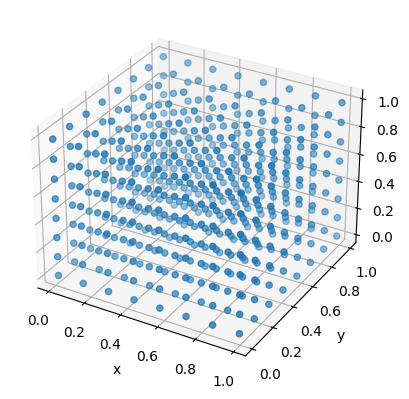

In [16]:
fig = plt.figure()

ax = plt.axes(projection="3d")
ax.scatter(X[:,0],X[:,1], X[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')

plt.show()

After discretizing the domain, we can now assemble the tensors for our quadratic function. If the problem was a linear PDE, this would only be a linear problem. The assembly of the tensor is the most expensive part of the computation.

In [17]:
from numba.core.errors import NumbaWarning
import warnings

warnings.simplefilter('ignore', category=NumbaWarning)

def calculate_matrices(X):
    for index, x_p in enumerate(X):
        Q = []
        V = []
        F = []
        Q_p = np.zeros((L,L))
        v_p = np.zeros(L)
        for i in range(L):
            for j in range(L):
                Q_p[i,j] = q_lambda(x_p[0], x_p[1], x_p[2], b[j], w[j][0], w[j][1], w[j][2], b[i], w[i][0], w[i][1], w[i][2])
            
            v_p[i] = v_lambda(x_p[0], x_p[1], x_p[2], b[i], w[i][0], w[i][1], w[i][2])
        F_p = f_lambda(x_p[0], x_p[1], x_p[2])

        Q.append(Q_p.copy())
        V.append(v_p.copy())
        F.append(F_p)

    return np.array(Q), np.array(V), np.array(F)


Q_np, V_np, F_np = jit(calculate_matrices)(X)

Now that the quadratic function is defined, we can perform least squares optimization to compute the coefficients of the ELM.

In [18]:
loss_func = lambda beta: beta.transpose()@Q_np@beta + V_np@beta + F_np
loss_jacobian = lambda beta: beta.transpose()@Q_np + V_np

final_beta = scipy.optimize.least_squares(loss_func,np.random.random(L), loss_jacobian)

All that is left to do is to plot and compare to the true solution.

In [19]:
ce_subbed = ce_final.replace(g, sym.Lambda((x,y,t), a*s_1(x,y,t)))
ce_poly = sym.Poly(ce_subbed, a)

g_term = ce_poly.coeffs()[0]
g_term = g_term.replace(s_1, sym.Lambda((x,y,t), sym.tanh(w_x*x + w_y*y + w_t*t + b_j)))
g_lambda = sym.lambdify((x,y,t, w_x, w_y, w_t, b_j), g_term)

const_term = ce_poly.coeffs()[1]
const_lambda = sym.lambdify((x,y,t), const_term)

def solution(x, y, t):
    for x_val,y_val in zip(x,y):
        H = np.array([final_beta.x[j]*g_lambda(x,y,t, w[j][0], w[j][1],w[j][2], b[j]) for j in range(L)])
        return sum(H) + const_lambda(x,y,t)

true_solution = sym.sin(2*sym.pi*x*y) + t*t*y + (t - 1)*x*y
true_sol_lambda = sym.lambdify((x,y,t), true_solution)

In [20]:
t_val =  0.5
xrange, yrange = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
zvals = solution(xrange,yrange,t_val)
zvals_true = true_sol_lambda(xrange,yrange,t_val)

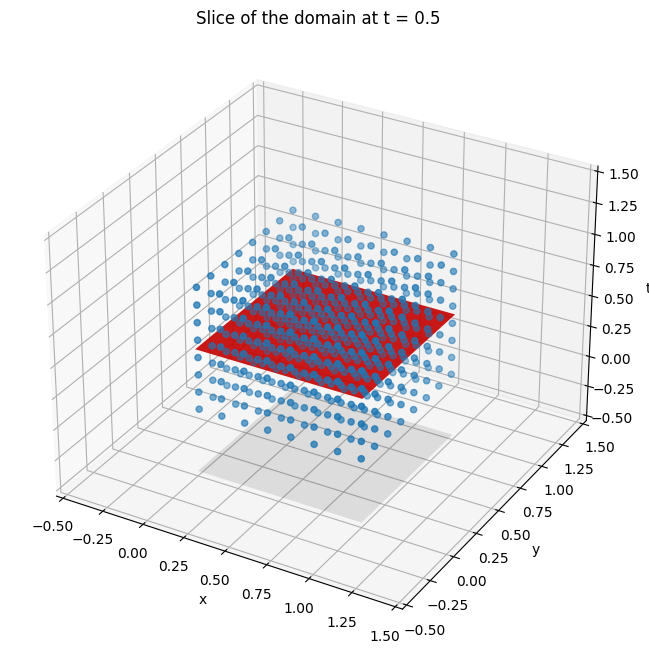

In [21]:
fig = plt.figure()
fig.set_size_inches((8,8))

surfx, surfy = np.meshgrid([0,1],[0,1])
tsurf = t_val*np.ones_like(surfx)

ax = plt.axes(projection="3d")
ax.scatter(X[:,0],X[:,1], X[:,2])
ax.plot_surface(surfx,surfy,tsurf,color="red", alpha=0.9)
ax.plot_surface(surfx,surfy,-0.5*np.ones_like(surfx),color="black", alpha=0.1)
ax.set_title(f"Slice of the domain at t = {round(t_val, 2)}")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
ax.set_xlim((-0.5,1.5))
ax.set_ylim((-0.5,1.5))
ax.set_zlim((-0.5,1.5))

plt.show()

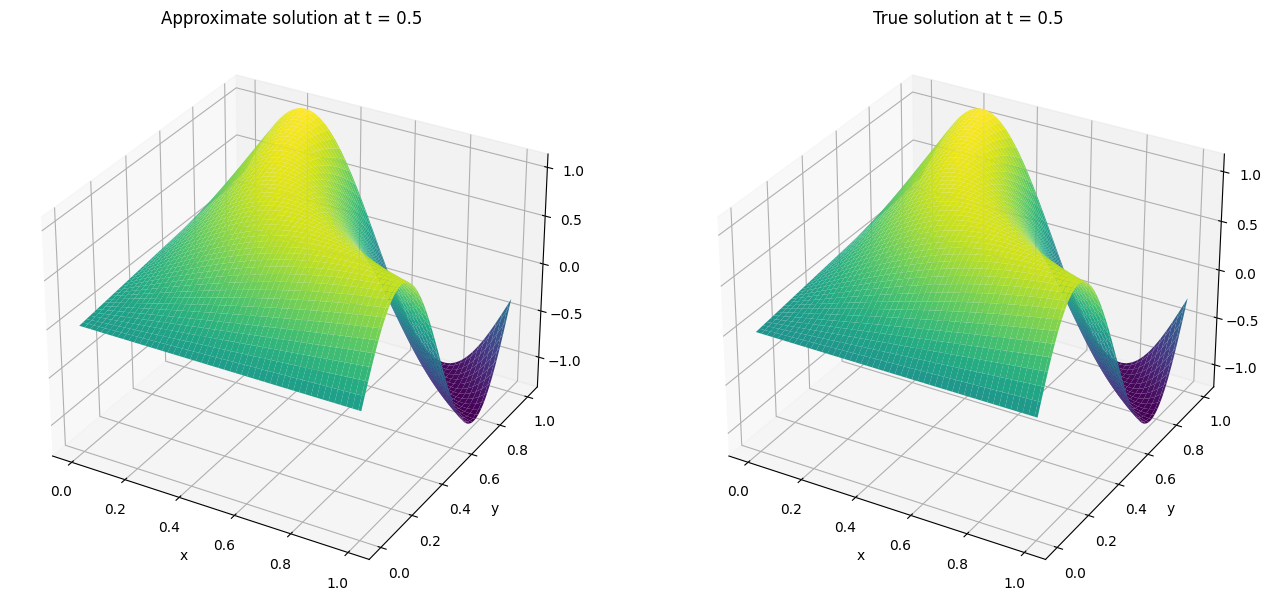

In [22]:
fig = plt.figure()
fig.set_size_inches((16,8))

ax_1 = fig.add_subplot(1,2,1,projection="3d")
ax_1.plot_surface(xrange,yrange, zvals, cmap="viridis")
ax_1.set_title(f"Approximate solution at t = {round(t_val, 2)}")
ax_1.set_xlabel('x')
ax_1.set_ylabel('y')

ax_2 = fig.add_subplot(1,2,2,projection="3d")
ax_2.plot_surface(xrange,yrange, zvals_true, cmap="viridis")
ax_2.set_title(f"True solution at t = {round(t_val, 2)}")
ax_2.set_xlabel('x')
ax_2.set_ylabel('y')

plt.show()

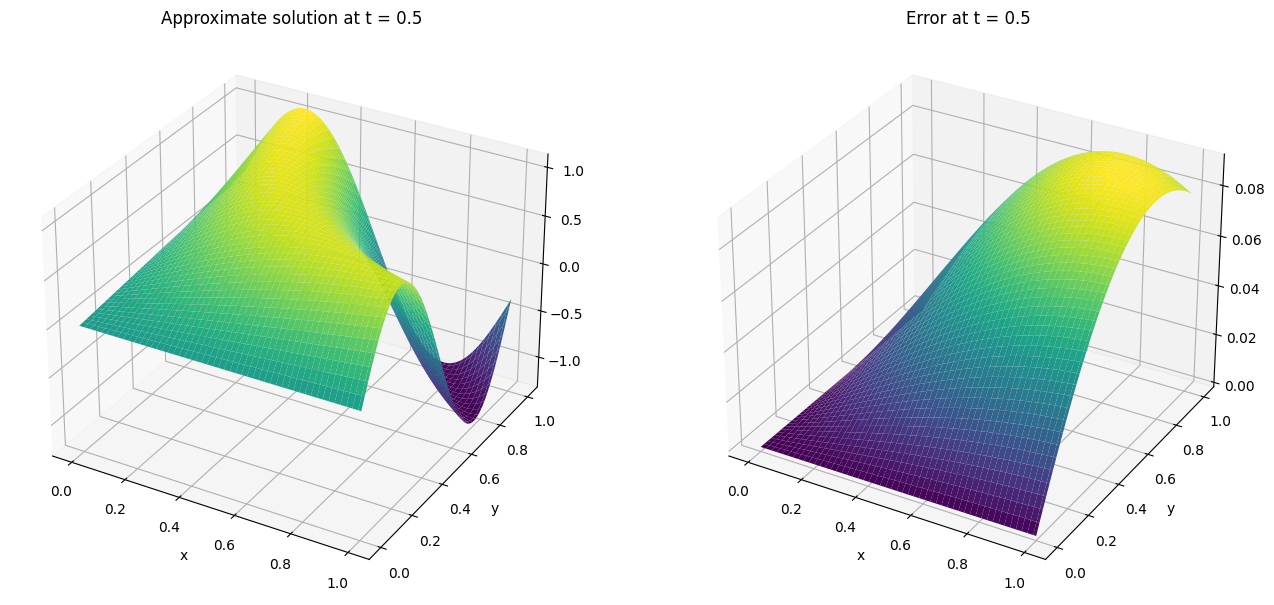

In [23]:
fig = plt.figure()
fig.set_size_inches((16,8))

ax_1 = fig.add_subplot(1,2,1,projection="3d")
ax_1.plot_surface(xrange,yrange, zvals, cmap="viridis")
ax_1.set_title(f"Approximate solution at t = {round(t_val, 2)}")
ax_1.set_xlabel('x')
ax_1.set_ylabel('y')

ax_2 = fig.add_subplot(1,2,2,projection="3d")
ax_2.plot_surface(xrange,yrange, abs(zvals - zvals_true), cmap="viridis")
ax_2.set_title(f"Error at t = {round(t_val, 2)}")
ax_2.set_xlabel('x')
ax_2.set_ylabel('y')

plt.show()